# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---


## Import Packages

In [25]:
import os
import csv
import cv2
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Cropping2D

## Read in an Image

Train on 1200 samples, validate on 300 samples
Epoch 1/10
1200/1200 [==============================] - 1s - loss: 3.5052 - val_loss: 0.4775
Epoch 2/10
1200/1200 [==============================] - 0s - loss: 0.4744 - val_loss: 0.3028
Epoch 3/10
1200/1200 [==============================] - 0s - loss: 0.1640 - val_loss: 0.2081
Epoch 4/10
1200/1200 [==============================] - 1s - loss: 0.1121 - val_loss: 0.2078
Epoch 5/10
1200/1200 [==============================] - 0s - loss: 0.0672 - val_loss: 0.1324
Epoch 6/10
1200/1200 [==============================] - 0s - loss: 0.0366 - val_loss: 0.1383
Epoch 7/10
1200/1200 [==============================] - 0s - loss: 0.0304 - val_loss: 0.1626ss: 0.030
Epoch 8/10
1200/1200 [==============================] - 0s - loss: 0.0221 - val_loss: 0.1652
Epoch 9/10
1200/1200 [==============================] - 1s - loss: 0.0474 - val_loss: 0.1716
Epoch 10/10
1200/1200 [==============================] - 1s - loss: 0.0983 - val_loss: 0.1673
dict_keys(['v

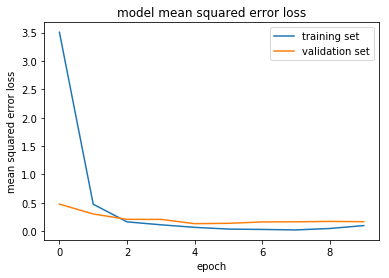

In [29]:
lines = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

images = []
measurements = []
correction = 0.2
#correction array for center, left and right images accessed in the loop below
cr_ar = np.array([0,correction,-correction])
for line in lines:
    for i in range(3):
        source_path = line[i] # 0 - center img, 1- left img and 2- right img
        filename = source_path.split('/')[-1]
        current_path = './data/IMG/'+filename 
        image = cv2.imread(current_path)
        images.append(image)
        measurement = float(line[3])
        measurements.append((measurement+cr_ar[i]))
        images.append(np.fliplr(image))
        measurements.append(-(measurement+cr_ar[i]))
    


X_train = np.array(images)
y_train = np.array(measurements)


#Augment the data

# Keras NN
model = Sequential()
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: (x / 255.0) - 0.5))
model.add(Flatten())
model.add(Dense(1))
model.compile(loss = 'mse',optimizer = 'adam')


history_object = model.fit(X_train,y_train,validation_split = 0.2,shuffle=True,nb_epoch = 10,verbose=1)
#"""
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save('model.h5')
#"""


## Code with Generator

Epoch 1/10
1200/1200 [==============================] - 1s - loss: 4.1096 - val_loss: 4.0668
Epoch 2/10
1200/1200 [==============================] - 1s - loss: 1.9014 - val_loss: 1.9708
Epoch 3/10
1200/1200 [==============================] - 1s - loss: 1.7177 - val_loss: 0.8297
Epoch 4/10
1200/1200 [==============================] - 1s - loss: 1.4465 - val_loss: 2.3395
Epoch 5/10
1200/1200 [==============================] - 1s - loss: 1.5878 - val_loss: 0.7022
Epoch 6/10
1200/1200 [==============================] - 1s - loss: 1.2595 - val_loss: 0.4272
Epoch 7/10
1200/1200 [==============================] - 1s - loss: 0.4544 - val_loss: 0.6893
Epoch 8/10
1200/1200 [==============================] - 1s - loss: 0.4500 - val_loss: 0.1322
Epoch 9/10
1200/1200 [==============================] - 1s - loss: 0.4136 - val_loss: 0.2764
Epoch 10/10
1200/1200 [==============================] - 1s - loss: 0.3018 - val_loss: 0.6653
dict_keys(['val_loss', 'loss'])


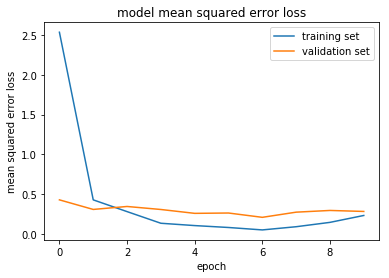

In [28]:
samples = []

with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

correction = 0.2
#correction array for center, left and right images accessed in the loop below
cr_ar = np.array([0,correction,-correction])

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        #shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                for i in range(3): # i = 0 - center img, 1- left img and 2- right img
                    current_path = './data/IMG/'+batch_sample[i].split('/')[-1]
                    image = cv2.imread(current_path)
                    angle = float(batch_sample[3])
                    images.append(image)
                    angles.append(angle+cr_ar[i])
                    images.append(np.fliplr(image))
                    angles.append(-(angle+cr_ar[i]))

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

        
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)


model = Sequential()
model.add(Lambda(lambda x: x/255 - 0.5,
        input_shape=(160,320,3),
        output_shape=(160,320,3)))
model.add(Cropping2D(cropping=((50,20), (0,0))))
model.add(Flatten())
model.add(Dense(1))
model.compile(loss = 'mse',optimizer = 'adam')
model.fit_generator(train_generator, samples_per_epoch= len(train_samples)*6,
                    validation_data=validation_generator,nb_val_samples=len(validation_samples),nb_epoch=10,verbose=1)


### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save('model.h5')

## Ideas for Lane Detection Pipeline

Now for the one with the solid yellow lane on the left. This one's more tricky!